# Modelagem Preditiva - Previsão de Temperatura Horária

Este notebook implementa modelos de machine learning para prever a temperatura horária.


In [8]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Configurações
POSTGRES_HOST = 'postgres'
POSTGRES_USER = 'postgres'
POSTGRES_PASSWORD = 'postgres'
POSTGRES_DB = 'inmet_db'

engine = create_engine(f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:5432/{POSTGRES_DB}')

# Configura variáveis de ambiente para S3/MinIO (necessário para salvar artefatos)
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'
os.environ['AWS_ACCESS_KEY_ID'] = 'minioadmin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minioadmin'
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

# Configura MLFlow
mlflow.set_tracking_uri('http://mlflow:5000')
mlflow.set_experiment('previsao_temperatura')

print("✅ MLFlow configurado com sucesso!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: previsao_temperatura")


✅ MLFlow configurado com sucesso!
Tracking URI: http://mlflow:5000
Experiment: previsao_temperatura


In [9]:
# Carrega dados tratados
query = """
SELECT * FROM dados_tratados
WHERE temperatura IS NOT NULL
ORDER BY datetime
"""

df = pd.read_sql(query, engine)
df['datetime'] = pd.to_datetime(df['datetime'])
print(f"Total de registros: {len(df)}")
df.head()


Total de registros: 7161


,id,datetime,data,hora_utc,precipitacao,pressao,radiacao,temperatura,umidade,vento_direcao,...,ano,mes,dia,hora,dia_semana,dia_ano,hora_sin,hora_cos,mes_sin,mes_cos
0,1,2024-01-01 00:00:00,2024-01-01,0000,0.0,1012.4,88.3,23.0,88.0,84.0,...,2024,1,1,0,0,1,0.000000,1.000000,0.5,0.866025
1,2,2024-01-01 01:00:00,2024-01-01,0100,0.0,1012.8,88.3,23.8,77.0,63.0,...,2024,1,1,1,0,1,0.258819,0.965926,0.5,0.866025
2,3,2024-01-01 02:00:00,2024-01-01,0200,0.0,1012.6,88.3,23.8,68.0,52.0,...,2024,1,1,2,0,1,0.500000,0.866025,0.5,0.866025
3,4,2024-01-01 03:00:00,2024-01-01,0300,0.0,1012.3,88.3,24.0,63.0,50.0,...,2024,1,1,3,0,1,0.707107,0.707107,0.5,0.866025
4,5,2024-01-01 04:00:00,2024-01-01,0400,0.0,1011.8,88.3,23.9,64.0,21.0,...,2024,1,1,4,0,1,0.866025,0.500000,0.5,0.866025


In [10]:
# Prepara features e target
# Features: variáveis meteorológicas + features temporais
feature_cols = [
    'umidade', 'pressao', 'radiacao', 'vento_velocidade', 'vento_direcao',
    'precipitacao', 'hora', 'mes', 'dia_ano',
    'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos'
]

# Remove colunas que não existem
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].fillna(0)
y = df['temperatura']

print(f"Features utilizadas: {feature_cols}")
print(f"Shape X: {X.shape}, Shape y: {y.shape}")


Features utilizadas: ['umidade', 'pressao', 'radiacao', 'vento_velocidade', 'vento_direcao', 'precipitacao', 'hora', 'mes', 'dia_ano', 'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos']
Shape X: (7161, 13), Shape y: (7161,)


In [11]:
# Split temporal (80% treino, 20% teste)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Treino: {len(X_train)} amostras")
print(f"Teste: {len(X_test)} amostras")


Treino: 5728 amostras
Teste: 1433 amostras


In [12]:
# Modelo 1: Random Forest
try:
    with mlflow.start_run(run_name='RandomForest') as run:
        model_rf = RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )
        
        print("Treinando modelo Random Forest...")
        model_rf.fit(X_train, y_train)
        
        # Predições
        y_pred_train = model_rf.predict(X_train)
        y_pred_test = model_rf.predict(X_test)
        
        # Métricas
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        # Log no MLFlow
        print("Registrando parâmetros e métricas no MLFlow...")
        mlflow.log_params({
            'model': 'RandomForest',
            'n_estimators': 100,
            'max_depth': 15
        })
        
        mlflow.log_metrics({
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'r2_test': r2_test
        })
        
        # Salva o modelo
        print("Salvando modelo no MLFlow...")
        mlflow.sklearn.log_model(model_rf, 'model')
        
        print(f"\n✅ Random Forest - RMSE Teste: {rmse_test:.4f}°C")
        print(f"✅ Random Forest - MAE Teste: {mae_test:.4f}°C")
        print(f"✅ Random Forest - R² Teste: {r2_test:.4f}")
        print(f"✅ Run ID: {run.info.run_id}")
        
        rf_run_id = run.info.run_id
        
except Exception as e:
    print(f"❌ Erro ao treinar/salvar modelo: {e}")
    import traceback
    traceback.print_exc()
    raise


Treinando modelo Random Forest...
Registrando parâmetros e métricas no MLFlow...
Salvando modelo no MLFlow...

✅ Random Forest - RMSE Teste: 3.0778°C
✅ Random Forest - MAE Teste: 2.4163°C
✅ Random Forest - R² Teste: -0.6031
✅ Run ID: df4145fd85704b01a64cf88d238fc5b1


In [13]:
# Modelo 2: Gradient Boosting
try:
    with mlflow.start_run(run_name='GradientBoosting') as run:
        model_gb = GradientBoostingRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        )
        
        print("Treinando modelo Gradient Boosting...")
        model_gb.fit(X_train, y_train)
        
        y_pred_train = model_gb.predict(X_train)
        y_pred_test = model_gb.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)
        
        print("Registrando parâmetros e métricas no MLFlow...")
        mlflow.log_params({
            'model': 'GradientBoosting',
            'n_estimators': 100,
            'max_depth': 5,
            'learning_rate': 0.1
        })
        
        mlflow.log_metrics({
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'r2_test': r2_test
        })
        
        print("Salvando modelo no MLFlow...")
        mlflow.sklearn.log_model(model_gb, 'model')
        
        print(f"\n✅ Gradient Boosting - RMSE Teste: {rmse_test:.4f}°C")
        print(f"✅ Gradient Boosting - MAE Teste: {mae_test:.4f}°C")
        print(f"✅ Gradient Boosting - R² Teste: {r2_test:.4f}")
        print(f"✅ Run ID: {run.info.run_id}")
        
        gb_run_id = run.info.run_id
        
except Exception as e:
    print(f"❌ Erro ao treinar/salvar modelo: {e}")
    import traceback
    traceback.print_exc()
    raise


Treinando modelo Gradient Boosting...
Registrando parâmetros e métricas no MLFlow...
Salvando modelo no MLFlow...

✅ Gradient Boosting - RMSE Teste: 3.2331°C
✅ Gradient Boosting - MAE Teste: 2.5651°C
✅ Gradient Boosting - R² Teste: -0.7689
✅ Run ID: 61c770b7bea2417a809a1bcfb1d366b7


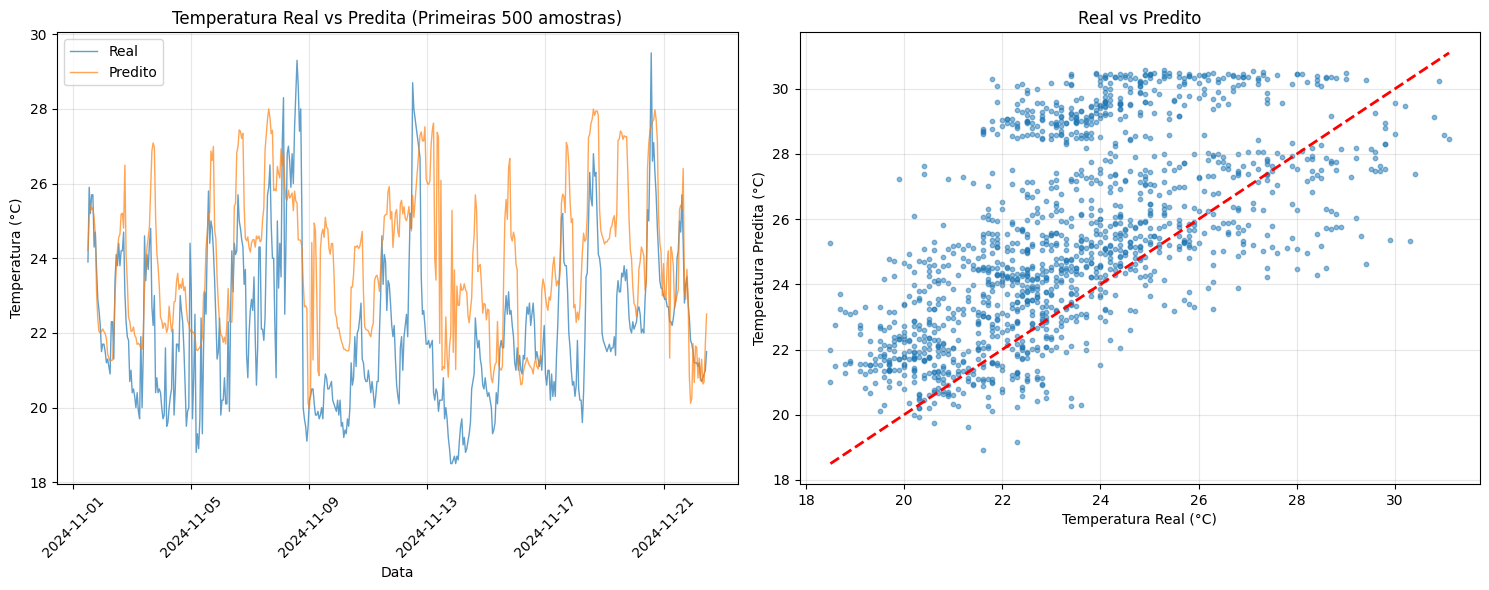

✅ Gráfico salvo no MLFlow!

RMSE Final: 3.0778°C


In [14]:
# Visualização: Real vs Predito (usando melhor modelo)
best_model = model_rf  # Random Forest geralmente performa melhor
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(15, 6))

# Série temporal
plt.subplot(1, 2, 1)
test_dates = df['datetime'].iloc[split_idx:split_idx+len(y_test)]
plt.plot(test_dates[:500], y_test.values[:500], label='Real', alpha=0.7, linewidth=1)
plt.plot(test_dates[:500], y_pred_best[:500], label='Predito', alpha=0.7, linewidth=1)
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura Real vs Predita (Primeiras 500 amostras)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_best, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predita (°C)')
plt.title('Real vs Predito')
plt.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = '/home/jovyan/work/resultados_predicao.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

# Salva gráfico no MLFlow (se o run ainda estiver ativo)
try:
    # Tenta encontrar o último run do RandomForest
    experiment = mlflow.get_experiment_by_name('previsao_temperatura')
    if experiment:
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], 
                                 filter_string="tags.mlflow.runName = 'RandomForest'",
                                 max_results=1)
        if not runs.empty:
            last_run_id = runs.iloc[0]['run_id']
            with mlflow.start_run(run_id=last_run_id):
                mlflow.log_artifact(fig_path, 'plots')
                print("✅ Gráfico salvo no MLFlow!")
except Exception as e:
    print(f"⚠️ Não foi possível salvar gráfico no MLFlow: {e}")

rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"\nRMSE Final: {rmse_final:.4f}°C")


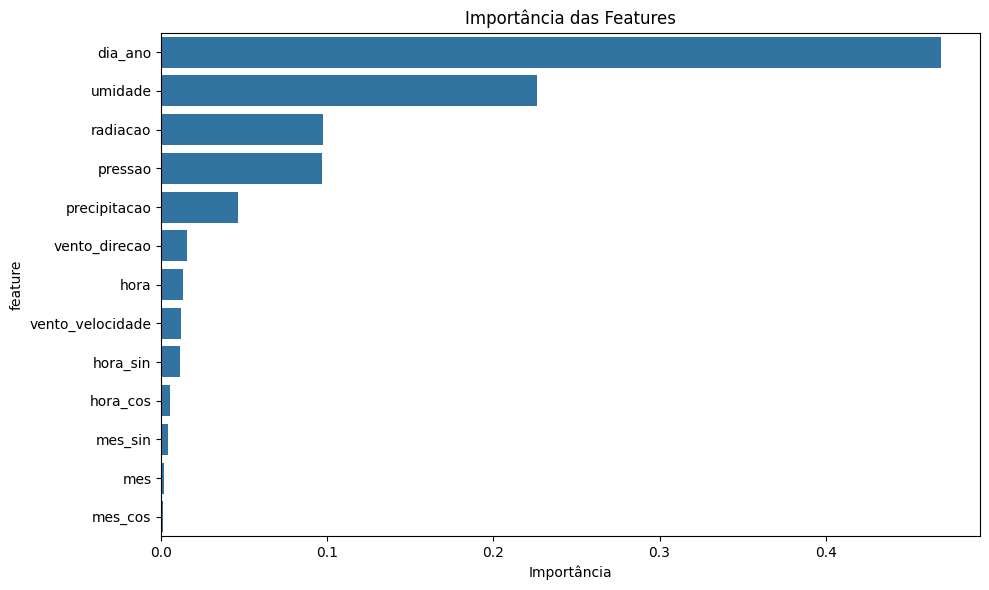

             feature  importance
8            dia_ano    0.469471
0            umidade    0.226397
2           radiacao    0.097640
1            pressao    0.096879
5       precipitacao    0.046407
4      vento_direcao    0.015569
6               hora    0.012800
3   vento_velocidade    0.012126
9           hora_sin    0.011082
10          hora_cos    0.005050
11           mes_sin    0.003942
7                mes    0.001401
12           mes_cos    0.001236


In [15]:
# Importância das features
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.tight_layout()
plt.savefig('/home/jovyan/work/importancia_features.png', dpi=300, bbox_inches='tight')
plt.show()

print(feature_importance)


In [16]:
# Salva predições no banco
try:
    # Garante que test_dates está definido
    if 'test_dates' not in locals():
        test_dates = df['datetime'].iloc[split_idx:split_idx+len(y_test)]
    
    predicoes_df = pd.DataFrame({
        'datetime': test_dates,
        'temperatura_real': y_test.values,
        'temperatura_predita': y_pred_best,
        'modelo_version': 'RandomForest_v1',
        'rmse': rmse_final
    })
    
    # Limpa a tabela antes de inserir (evita duplicatas)
    from sqlalchemy import text
    with engine.connect() as conn:
        conn.execute(text("DELETE FROM predicoes_temperatura"))
        conn.commit()
    
    # Salva no banco
    predicoes_df.to_sql('predicoes_temperatura', engine, if_exists='append', index=False)
    
    print(f"✅ Predições salvas no banco de dados: {len(predicoes_df)} registros")
    print(f"✅ RMSE: {rmse_final:.4f}°C")
    print(f"✅ Período: {test_dates.min()} a {test_dates.max()}")
    
except Exception as e:
    print(f"❌ Erro ao salvar predições: {e}")
    import traceback
    traceback.print_exc()


✅ Predições salvas no banco de dados: 1433 registros
✅ RMSE: 3.0778°C
✅ Período: 2024-11-01 12:00:00 a 2024-12-31 23:00:00
